# Імпортуємо базові бібліотеки

In [1]:
import numpy as np
import pandas as pd
import mysql.connector

import os
import sys
print(f"Python: {sys.version}")

Python: 3.9.13 (tags/v3.9.13:6de2ca5, May 17 2022, 16:36:42) [MSC v.1929 64 bit (AMD64)]


# Імпортуємо бібліотеки

In [2]:
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import cv2
import matplotlib.pyplot as plt
import PIL.Image

from matplotlib import style
style.use('fivethirtyeight')

In [3]:
# path to data
data_path = "./ClassificationDataSet"
train_path = data_path + "/Train"
test_path = data_path + "/Test"

classes_count = len(os.listdir(train_path))
print(f"Classes count: {classes_count}")

Classes count: 43


In [4]:
labels = pd.read_csv(data_path + "/Labels.csv")
classes = dict(zip(labels["key"], labels["value"]))
for key, value in classes.items():
    print(f"{key}: {value}")

0: Speed limit (20km/h)
1: Speed limit (30km/h)
2: Speed limit (50km/h)
3: Speed limit (60km/h)
4: Speed limit (70km/h)
5: Speed limit (80km/h)
6: End of speed limit (80km/h)
7: Speed limit (100km/h)
8: Speed limit (120km/h)
9: No passing
10: No passing veh over 3.5 tons
11: Right-of-way at intersection
12: Priority road
13: Yield
14: Stop
15: No vehicles
16: Veh > 3.5 tons prohibited
17: No entry
18: General caution
19: Dangerous curve left
20: Dangerous curve right
21: Double curve
22: Bumpy road
23: Slippery road
24: Road narrows on the right
25: Road work
26: Traffic signals
27: Pedestrians
28: Children crossing
29: Bicycles crossing
30: Beware of ice/snow
31: Wild animals crossing
32: End speed + passing limits
33: Turn right ahead
34: Turn left ahead
35: Ahead only
36: Go straight or right
37: Go straight or left
38: Keep right
39: Keep left
40: Roundabout mandatory
41: End of no passing
42: End no passing veh > 3.5 tons


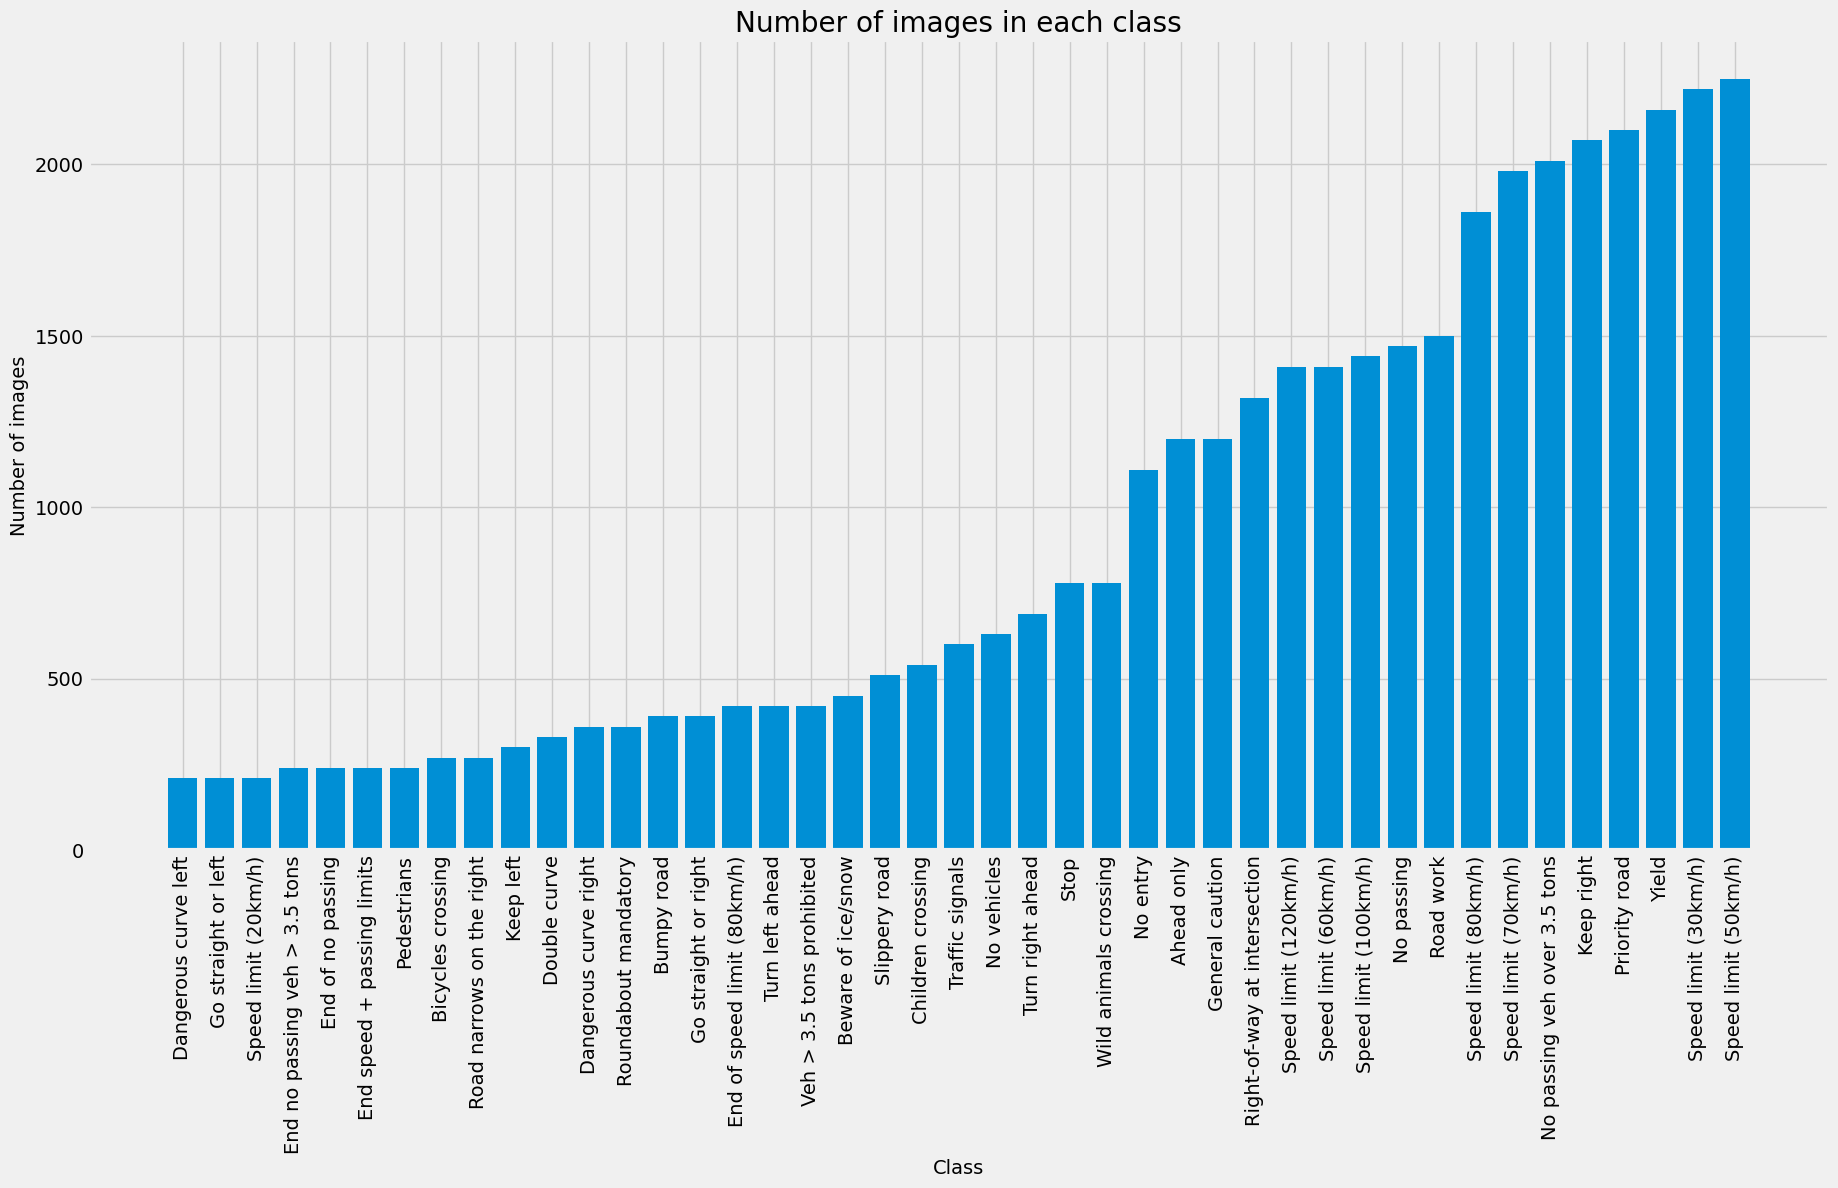

In [5]:
folders = os.listdir(train_path)

train_number = []
class_number = []

for folder in folders:
    train_files = os.listdir(train_path + "/" + folder)
    train_number.append(len(train_files))
    class_number.append(classes[int(folder)])

# sorting data by ascending of number of images
zipped_list = zip(train_number, class_number)
sorted_pairs = sorted(zipped_list)
tuples = zip(*sorted_pairs)
train_number, class_number = [list(tuple) for tuple in tuples]

# ploting data
plt.figure(figsize=(20, 10))
plt.bar(class_number, train_number)
plt.title("Number of images in each class")
plt.xlabel("Class")
plt.ylabel("Number of images")
plt.rcParams.update({'font.size': 24})
plt.xticks(rotation=90)
plt.show()

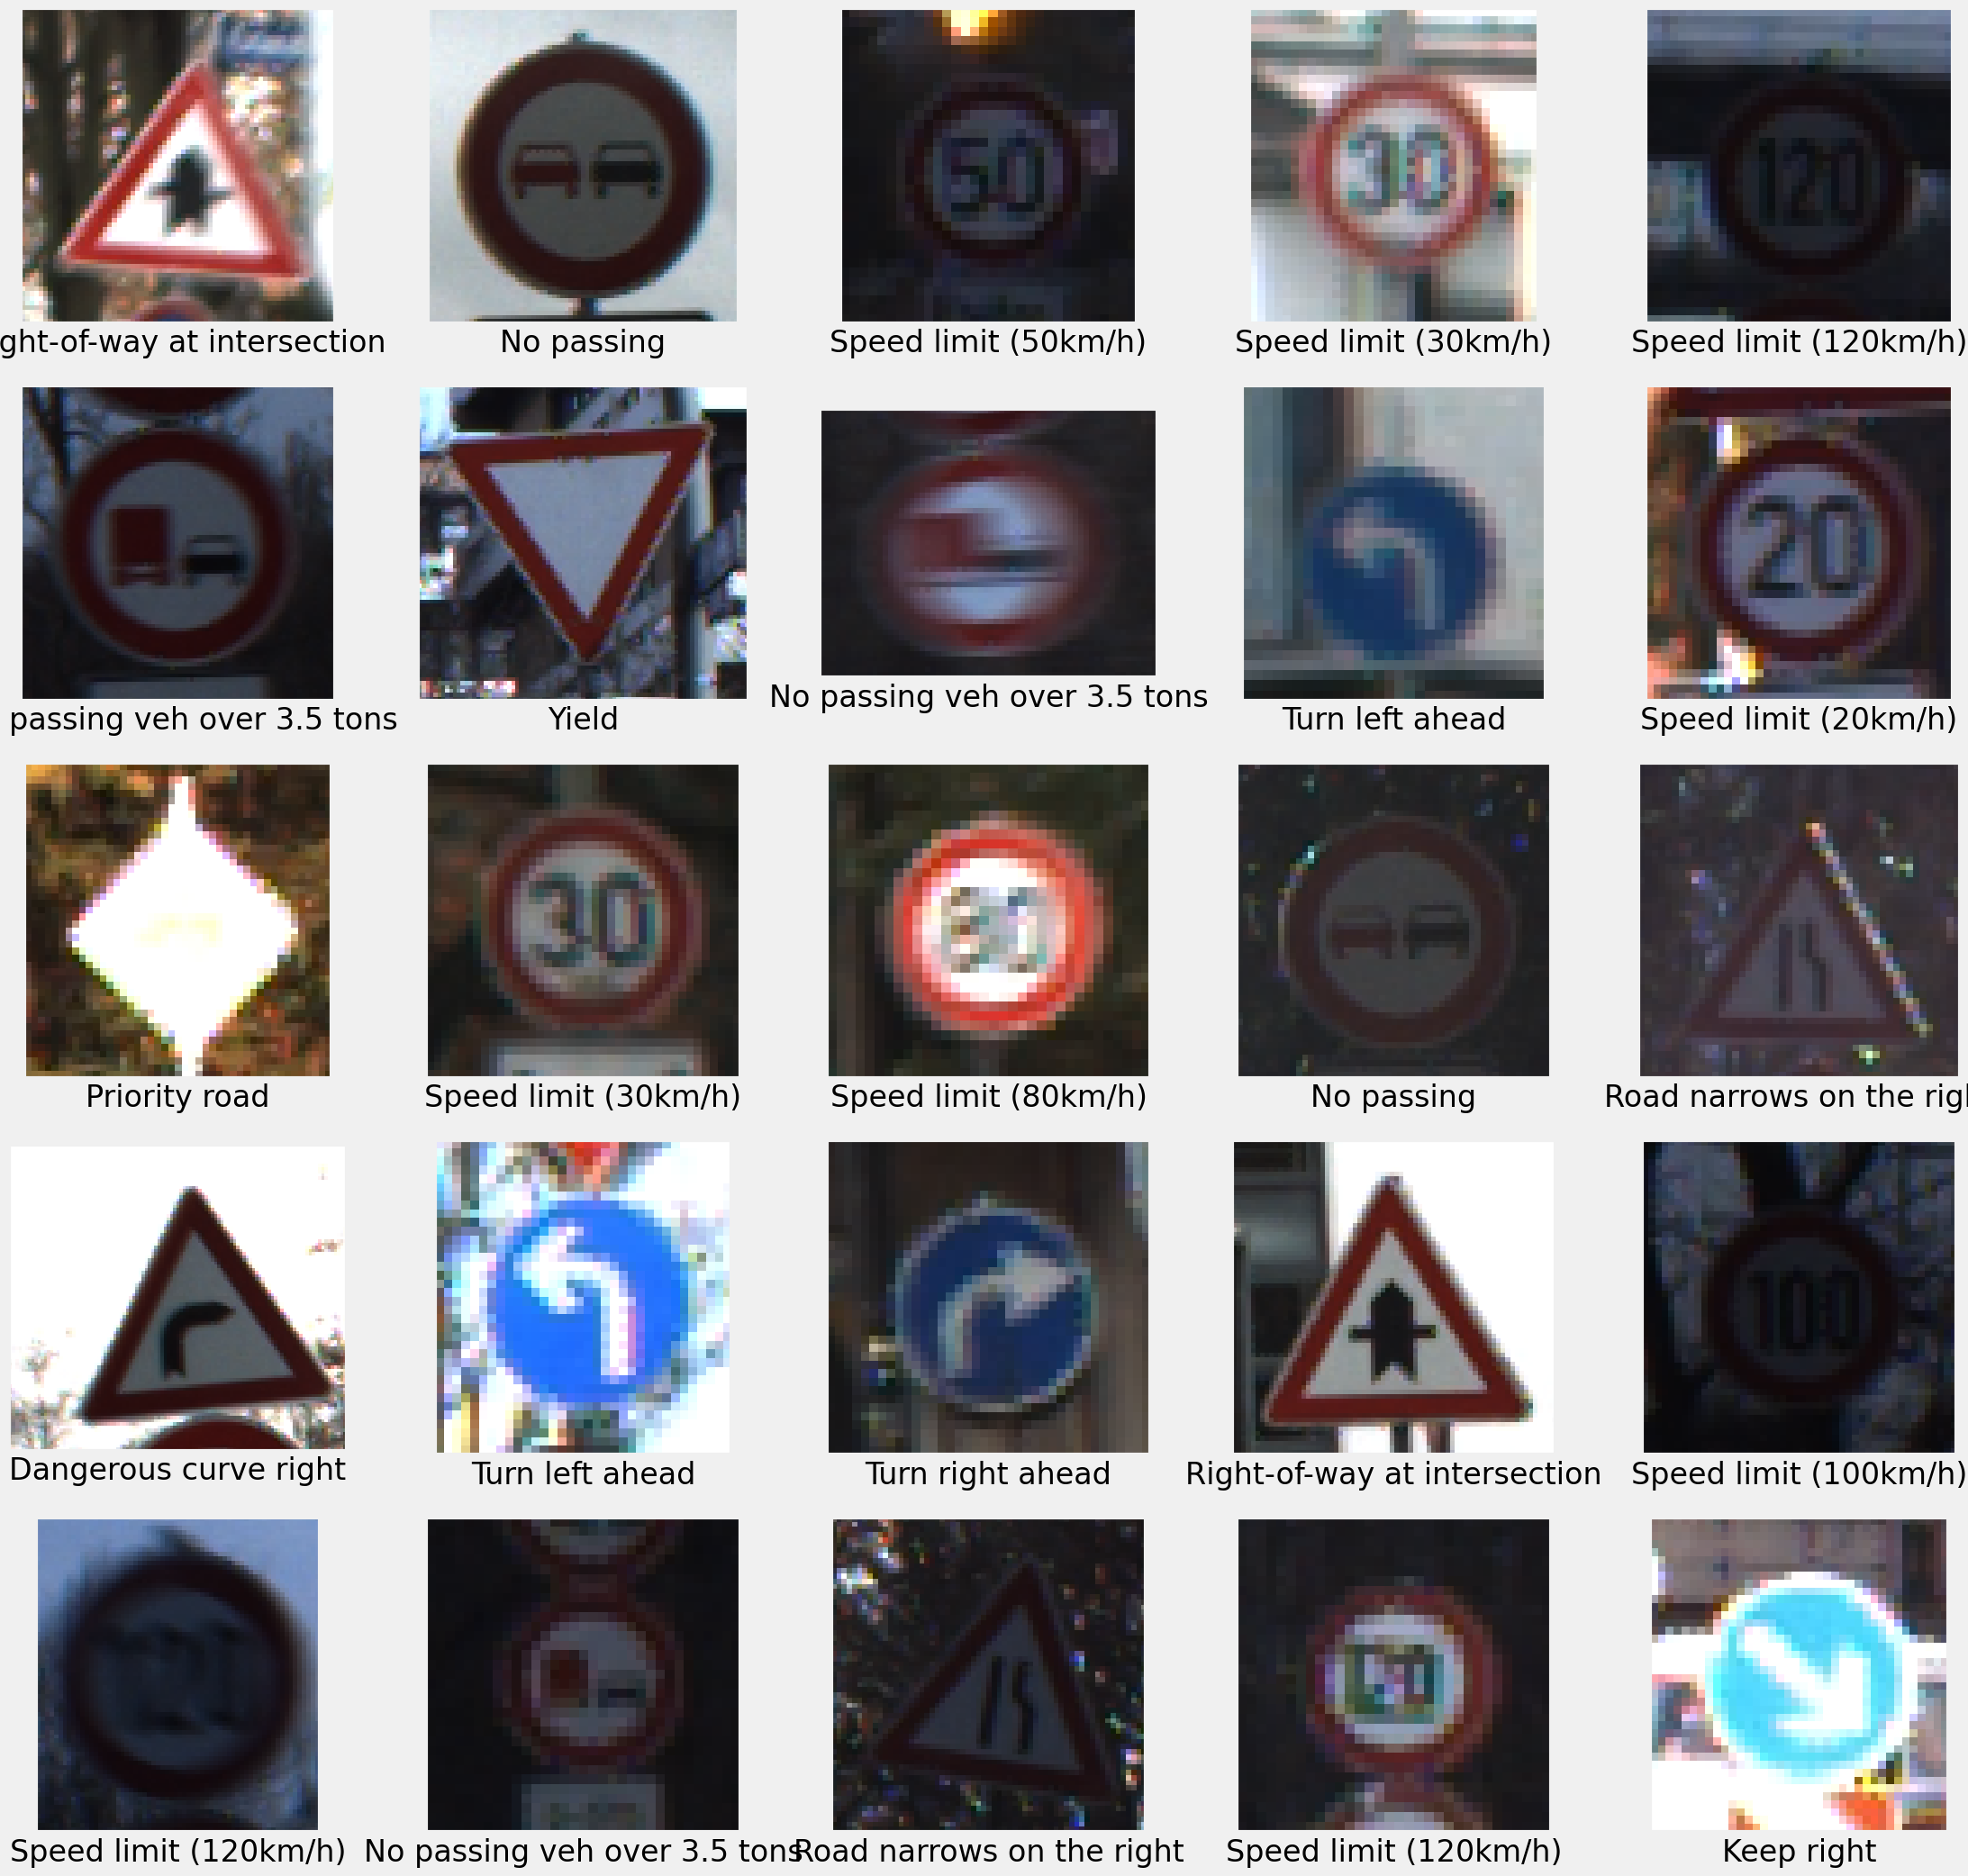

In [6]:
from random import randint
Image = PIL.Image

test_info = pd.read_csv(data_path + "/Test.csv")
images = test_info["Path"].values

rows, cols = 5, 5
plt.figure(figsize=(25, 25))

for i in range(rows * cols):
    index = randint(0, len(images))
    image = Image.open(data_path + "/" + images[index])
    plt.subplot(rows, cols, i + 1)
    plt.imshow(image)
    plt.xlabel(classes[test_info["ClassId"][index]])
    plt.xticks([])
    plt.yticks([])

# Завантажуємо дані для навчання

In [7]:
all_images = []
image_labels = []

IMG_HEIGHT = 32
IMG_WIDTH = 32
channels = 3

for i in range(classes_count):
    path = os.path.join(train_path, str(i))
    images = os.listdir(path)

    for img in images:
        try:
            image = cv2.imread(path + "/" + img)
            image_from_array = Image.fromarray(image, "RGB")
            resized_image = image_from_array.resize((IMG_HEIGHT, IMG_WIDTH))
            all_images.append(np.array(resized_image))
            image_labels.append(i)
        except:
            print(f"Error on file: {img}")

print("Loading completed")

all_images = np.array(all_images)
image_labels = np.array(image_labels)

print(f"Train data shape: {all_images.shape}")

Loading completed
Train data shape: (39209, 32, 32, 3)


# Розбиваємо дані на тренувальні та тестові

In [8]:
# split data
x_train, x_test, y_train, y_test = train_test_split(all_images, image_labels, test_size=0.3, random_state=42, shuffle=True)

x_train = x_train / 255
x_test = x_test / 255

print(f"Train data shape: {x_train.shape}")
print(f"Test data shape: {x_test.shape}")
print(f"Train labels shape: {y_train.shape}")
print(f"Test labels shape: {y_test.shape}")

Train data shape: (27446, 32, 32, 3)
Test data shape: (11763, 32, 32, 3)
Train labels shape: (27446,)
Test labels shape: (11763,)


# Перетворення категоіральних даних в числові

In [9]:
from keras.utils import to_categorical

y_train = to_categorical(y_train, classes_count)
y_test = to_categorical(y_test, classes_count)

print(f"Train labels shape: {y_train.shape}")
print(f"Test labels shape: {y_test.shape}")

Train labels shape: (27446, 43)
Test labels shape: (11763, 43)


In [82]:
model = keras.Sequential([
    keras.layers.Conv2D(32, (5, 5), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, channels)),
    keras.layers.Dense(32, activation='relu'),

    keras.layers.Conv2D(64, (5, 5), activation='relu'),
    keras.layers.Dense(64, activation='relu'),

    keras.layers.Conv2D(128, (5, 5), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),

    keras.layers.Conv2D(256, (5, 5), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),

    keras.layers.Dropout(0.25),
    keras.layers.Flatten(),
    keras.layers.Dense(classes_count, activation='softmax')
])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 28, 28, 32)        2432      
                                                                 
 dense_13 (Dense)            (None, 28, 28, 32)        1056      
                                                                 
 conv2d_17 (Conv2D)          (None, 24, 24, 64)        51264     
                                                                 
 dense_14 (Dense)            (None, 24, 24, 64)        4160      
                                                                 
 conv2d_18 (Conv2D)          (None, 20, 20, 128)       204928    
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 10, 10, 128)      0         
 2D)                                                             
                                                      

In [83]:
learning_rate = 0.001
epochs = 30

opt = Adam(learning_rate=learning_rate, decay=learning_rate / epochs)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [84]:
aug = ImageDataGenerator(
    rotation_range=0.10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    fill_mode="nearest")

history = model.fit(
    aug.flow(x_train, y_train, batch_size=32),
    validation_data=(x_test, y_test),
    steps_per_epoch=x_train.shape[0] // 32,
    epochs=epochs,
    verbose=1
)

Epoch 1/30
857/857 [==============================] - 120s 139ms/step - loss: 1.4882 - accuracy: 0.5702 - val_loss: 0.1290 - val_accuracy: 0.9569
Epoch 2/30
857/857 [==============================] - 121s 141ms/step - loss: 0.2195 - accuracy: 0.9334 - val_loss: 0.0324 - val_accuracy: 0.9906
Epoch 3/30
857/857 [==============================] - 120s 140ms/step - loss: 0.1171 - accuracy: 0.9658 - val_loss: 0.0198 - val_accuracy: 0.9947
Epoch 4/30
857/857 [==============================] - 121s 142ms/step - loss: 0.0810 - accuracy: 0.9756 - val_loss: 0.0221 - val_accuracy: 0.9932
Epoch 5/30
857/857 [==============================] - 117s 137ms/step - loss: 0.0618 - accuracy: 0.9808 - val_loss: 0.0173 - val_accuracy: 0.9955
Epoch 6/30
857/857 [==============================] - 118s 137ms/step - loss: 0.0573 - accuracy: 0.9839 - val_loss: 0.0074 - val_accuracy: 0.9981
Epoch 7/30
857/857 [==============================] - 118s 138ms/step - loss: 0.0444 - accuracy: 0.9860 - val_loss: 0.0116 -

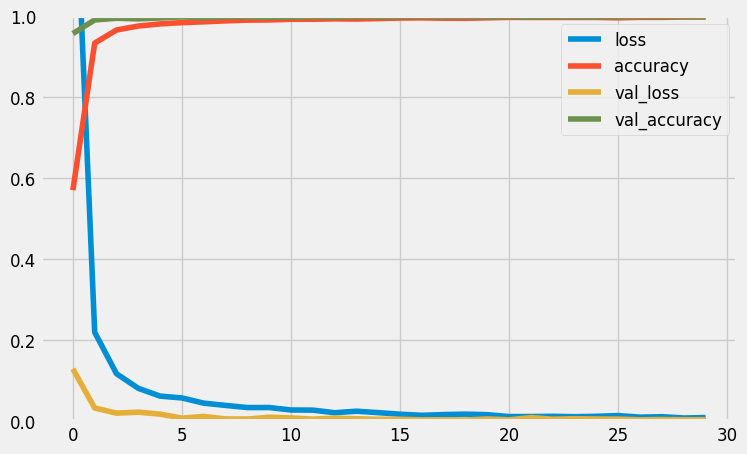

In [85]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

# Збереження моделі

In [86]:
model.save("sign_classifier_modified_v5.h5")

# Збереження інформації про модель в базу даних

In [46]:
from db_manager import *

db = Database()

Connected to networks_db database.
Executed query: SHOW COLUMNS FROM networks
Executed query: SHOW COLUMNS FROM configurations
Executed query: SHOW COLUMNS FROM results
Executed query: SHOW COLUMNS FROM training_process


In [61]:
# add model to db
name = "Traffic sign classifier"
db.networks_table.add_row((name, get_current_datetime()))
network_id = db.networks_table.get_rows(f"`name` = '{name}'")[0]['id']
print(f"Network id: {network_id}")

Executed query: INSERT INTO networks (name, created_at) VALUES (%s, %s)
Executed query: SELECT * FROM networks WHERE `name` = 'Traffic sign classifier'
Network id: 12


In [47]:
# save config
network_id = 12
architecture = [model.layers[i].get_config() for i in range(len(model.layers))]
architecture = json.dumps(architecture)
opt_data = opt.get_config()
for key in opt_data.keys():
    if type(opt_data[key]) == np.float32:
        opt_data[key] = float(opt_data[key])
hyperparameters = json.dumps({
    "learning_rate": learning_rate,
    "epochs": epochs,
    "optimizer": opt_data
})
configuration_id = db.configurations_table.add_row((network_id, architecture, hyperparameters))
print(f"Configuration id: {configuration_id}")

Executed query: INSERT INTO configurations (network_id, architecture, hyperparameters) VALUES (%s, %s, %s)
Configuration id: 20


In [48]:
# save training history
for epoch in range(epochs):
    db.training_process_table.add_row((
        configuration_id, epoch,
        history.history['loss'][epoch],
        history.history['accuracy'][epoch],
        history.history['val_loss'][epoch],
        history.history['val_accuracy'][epoch]
    ))

Executed query: INSERT INTO training_process (configuration_id, epoch, loss, accuracy, val_loss, val_accuracy) VALUES (%s, %s, %s, %s, %s, %s)
Executed query: INSERT INTO training_process (configuration_id, epoch, loss, accuracy, val_loss, val_accuracy) VALUES (%s, %s, %s, %s, %s, %s)
Executed query: INSERT INTO training_process (configuration_id, epoch, loss, accuracy, val_loss, val_accuracy) VALUES (%s, %s, %s, %s, %s, %s)
Executed query: INSERT INTO training_process (configuration_id, epoch, loss, accuracy, val_loss, val_accuracy) VALUES (%s, %s, %s, %s, %s, %s)
Executed query: INSERT INTO training_process (configuration_id, epoch, loss, accuracy, val_loss, val_accuracy) VALUES (%s, %s, %s, %s, %s, %s)
Executed query: INSERT INTO training_process (configuration_id, epoch, loss, accuracy, val_loss, val_accuracy) VALUES (%s, %s, %s, %s, %s, %s)
Executed query: INSERT INTO training_process (configuration_id, epoch, loss, accuracy, val_loss, val_accuracy) VALUES (%s, %s, %s, %s, %s, %s)

# Завантаження моделі

In [87]:
model = keras.models.load_model("sign_classifier_modified_v5.h5")
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 28, 28, 32)        2432      
                                                                 
 dense_13 (Dense)            (None, 28, 28, 32)        1056      
                                                                 
 conv2d_17 (Conv2D)          (None, 24, 24, 64)        51264     
                                                                 
 dense_14 (Dense)            (None, 24, 24, 64)        4160      
                                                                 
 conv2d_18 (Conv2D)          (None, 20, 20, 128)       204928    
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 10, 10, 128)      0         
 2D)                                                             
                                                      

In [88]:
test_info = pd.read_csv(data_path + "/Test.csv")

test_images = []
test_labels = []

for index, row in test_info.iterrows():
    image = cv2.imread(data_path + "/" + row["Path"])
    image_from_array = Image.fromarray(image, "RGB")
    resized_image = image_from_array.resize((IMG_HEIGHT, IMG_WIDTH))
    test_images.append(np.array(resized_image))
    test_labels.append(row["ClassId"])

test_images = np.array(test_images)
test_labels = np.array(test_labels)

test_images = test_images / 255

print(f"Test data shape: {test_images.shape}")
print(f"Test labels shape: {test_labels.shape}")

Test data shape: (12630, 32, 32, 3)
Test labels shape: (12630,)


In [89]:
from sklearn.metrics import accuracy_score

predictions = model.predict(test_images)
predictions = np.argmax(predictions, axis=1)

print(f"Accuracy: {accuracy_score(test_labels, predictions)}")

395/395 [==============================] - 11s 29ms/step
Accuracy: 0.9795724465558194


# Візуалізація точності по класах

In [81]:
from sklearn.metrics import confusion_matrix

cf = confusion_matrix(test_labels, predictions)
classwise_accuracy = cf.diagonal() / cf.sum(axis=1) * 100
cls_acc_df = pd.DataFrame({"Class": [classes[i] for i in range (classes_count)], "Accuracy": classwise_accuracy.tolist()}, columns=["Class", "Accuracy"])
print(cls_acc_df.sort_values(by=["Accuracy"], ascending=True))

                            Class    Accuracy
30             Beware of ice/snow   83.333333
22                     Bumpy road   83.333333
39                      Keep left   90.000000
18                General caution   95.897436
6     End of speed limit (80km/h)   96.000000
3            Speed limit (60km/h)   97.555556
40           Roundabout mandatory   97.777778
24      Road narrows on the right   97.777778
17                       No entry   98.055556
5            Speed limit (80km/h)   98.253968
37            Go straight or left   98.333333
28              Children crossing   98.666667
38                     Keep right   98.840580
21                   Double curve   98.888889
35                     Ahead only   98.974359
8           Speed limit (120km/h)   99.111111
4            Speed limit (70km/h)   99.242424
26                Traffic signals   99.444444
15                    No vehicles   99.523810
33               Turn right ahead   99.523810
9                      No passing 

# Збереження інформації про точність по класах в базу даних

In [58]:
configuration_id

array([100.        , 100.        ,  99.6       ,  97.55555556,
        99.24242424,  98.25396825,  96.        ,  99.77777778,
        99.11111111,  99.58333333,  99.6969697 , 100.        ,
        99.71014493,  99.72222222, 100.        ,  99.52380952,
       100.        ,  98.05555556,  95.8974359 , 100.        ,
       100.        ,  98.88888889,  83.33333333, 100.        ,
        97.77777778,  99.58333333,  99.44444444, 100.        ,
        98.66666667, 100.        ,  83.33333333,  99.62962963,
       100.        ,  99.52380952, 100.        ,  98.97435897,
       100.        ,  98.33333333,  98.84057971,  90.        ,
        97.77777778, 100.        , 100.        ])

In [54]:
metrics_type = "classwise_accuracy"
result_id = db.results_table.add_row((
    configuration_id,
    json.dumps(classwise_accuracy.tolist()),
    metrics_type
))

Executed query: INSERT INTO results (configuration_id, result, metric_type) VALUES (%s, %s, %s)


# Візуалізація передбачення

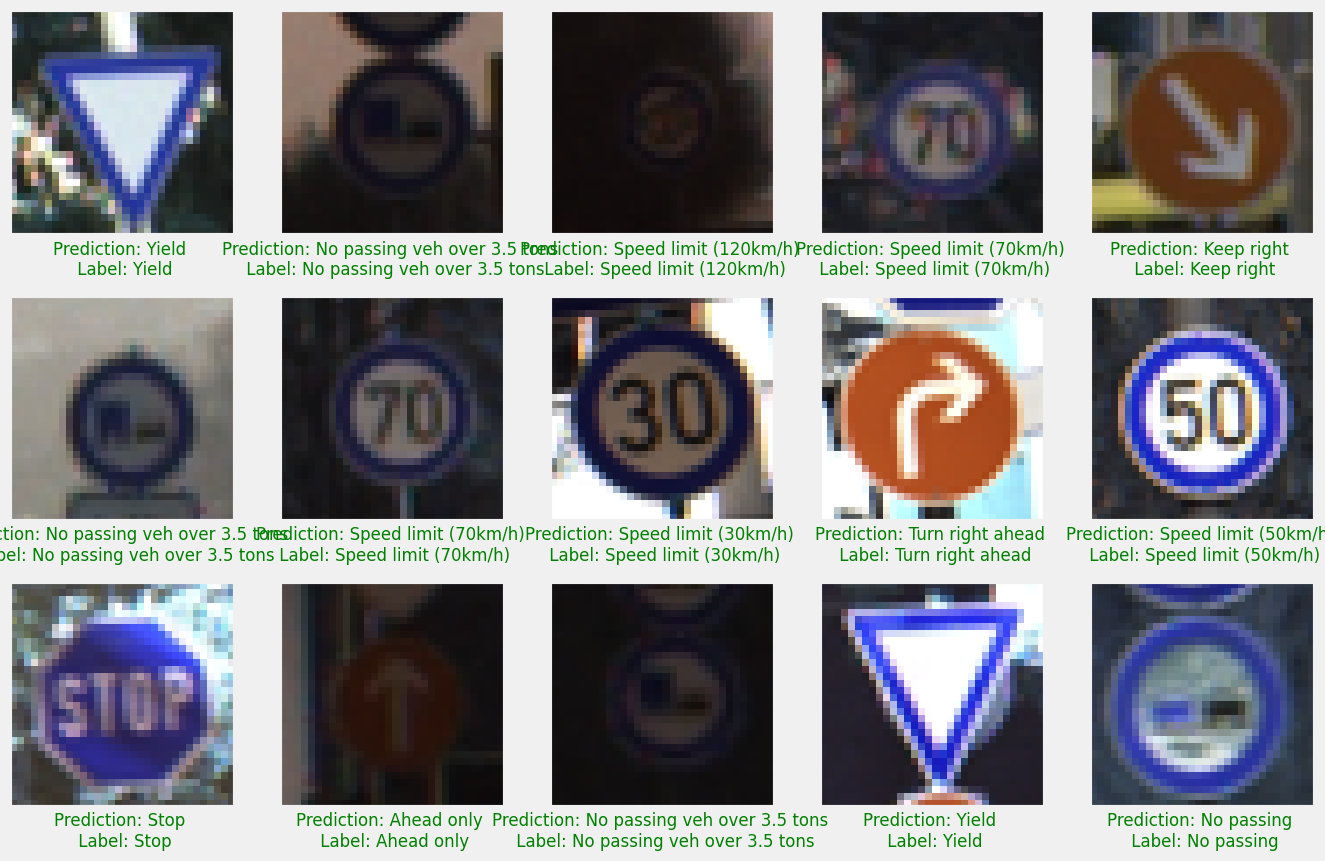

In [55]:
rows = 3
cols = 5

plt.figure(figsize=(15, 10))

start_index = randint(0, len(test_images) - rows * cols)

# set font size
plt.rcParams.update({'font.size': 12})

for i in range(rows * cols):
    index = start_index + i
    plt.subplot(rows, cols, i + 1)
    plt.xticks([])
    plt.yticks([])

    prediction = classes[predictions[index]]
    label = classes[test_labels[index]]

    color = "green" if prediction == label else "red"
    plt.xlabel(f"Prediction: {prediction} \n Label: {label}", color=color)
    plt.imshow(test_images[index])
plt.show()